In [68]:
import numpy as np
from astropy.io import fits
from pylab import *

In [15]:
!pip install dpkt scapy

     |████████████████████████████████| 1.1 MB 5.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261554 sha256=8a755142104b6210111a9d6f8a28cfa285298662af0c53ae785566ed781a34d8
  Stored in directory: /home/ban115/.cache/pip/wheels/c1/fa/90/97bfc7d75d3a6540b4ebd86589454312390fb1b99764f0ecba
Successfully built scapy


In [16]:
import dpkt
import scapy

In [32]:
from scapy.all import *


In [328]:
from craco.cardcap import get_single_packet_dtype
nant = 30
npol = 2
samp_per_int = 64 # samples per integration = 
samp_per_frame = 2048
int_per_frame = samp_per_frame // samp_per_int
nprod = nant*(nant+1)//2*npol # bug in nprod off by 1
dtype = get_single_packet_dtype(nprod, True)
packets_per_frame = int_per_frame * 36 * 4
dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('zero2', '<u4'), ('zero3', '<u4'), ('data', '<i2', (930, 2))])

In [588]:
last_ts = None
diffs = []
fout = open('packets.bin', 'wb')
fname = '/tmp/traces/tuesday_fixmeta_2.pcap'

fname = '/tmp/traces/tuesday_fixmeta_polsum_moreint.pcap'
fname = '/tmp/traces/tuesday_fixmeta_polsum_moreint.pcap'
fname = '/tmp/traces/tuesday_mettermeta.pcap'
fname = '/tmp/traces/wed_debug_2.pcap'
f = open(fname, 'rb')
pcap = dpkt.pcap.Reader(f)
for ipkt, (ts, buf) in enumerate(pcap):
    
    if last_ts is not None:
        diff = ts - last_ts
    else:
        diff = 0
        
    last_ts = ts
        
    #print(ipkt, str(datetime.datetime.utcfromtimestamp(ts)), len(buf), diff*1e6, buf[66:74])              
    eth = dpkt.ethernet.Ethernet(buf)
    diffs.append(diff)
    
    if len(buf) == 4166: # full size packet
        payload = buf[66:-4] # remove CRC
    else:
        payload = buf[66+4:-4] # With immediate adn remove CRC
        
    if ipkt >= 3544 - 1: # first SEND_FIRST packet
        fout.write(payload)
                
    if ipkt == 50000:
        break
        
fout.close()
        
   


npackets_per_frame=4608
23.87152777777778


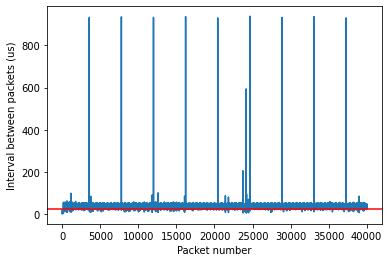

In [589]:
plot(np.array(diffs[:50000])*1e6)
xlabel('Packet number')
ylabel('Interval between packets (us)')
nint_per_frame = 2048//32 // 2
npackets_per_frame = 36*4*nint_per_frame
print(f'npackets_per_frame={npackets_per_frame}')
expected_interval = 110e-3/npackets_per_frame
print(expected_interval*1e6)
axhline(expected_interval*1e6, c='r')
#ylim(0,100)

In [590]:
packets = np.fromfile('packets.bin', dtype=dtype)

In [591]:
packets[:16]['frame_id']

array([6340640, 6340704, 6340768, 6340832, 6340896, 6340960, 6341024,
       6341088, 6341152, 6341216, 6341280, 6341344, 6341408, 6341472,
       6341536, 6341600], dtype=uint64)

In [592]:
(packets['frame_id'][1:] - packets['frame_id'][:-1])[:1024]

array([                  64,                   64,                   64,
       ...,                   64,                   64,
       18446744073709549632], dtype=uint64)

Text(0, 0.5, 'frame_id')

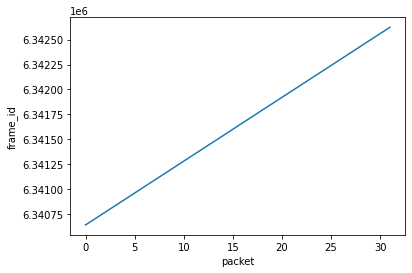

In [593]:
plot(packets['frame_id'][:32])
xlabel('packet')
ylabel('frame_id')


[64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64]
[6340640 6340704 6340768 6340832 6340896 6340960 6341024 6341088 6341152
 6341216 6341280 6341344 6341408 6341472 6341536 6341600 6341664 6341728
 6341792 6341856 6341920 6341984 6342048 6342112 6342176 6342240 6342304
 6342368 6342432 6342496 6342560 6342624]


Text(0, 0.5, 'FrameID increment')

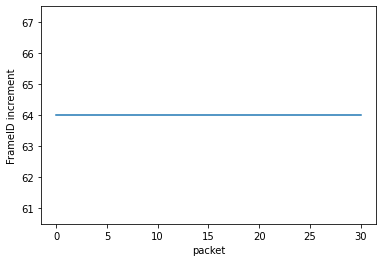

In [649]:
fid = packets['frame_id']
fdiff = fid[1:] - fid[0:-1]
off = 32*93
plot(fdiff[off:31+off])
print(fdiff[off:31+off])
print(fid[off:32+off])
xlabel('packet')
ylabel('FrameID increment')


Text(0, 0.5, 'Message')

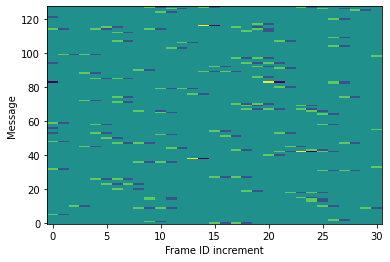

In [654]:
fdiff = fid[1:] - fid[0:-1]
off = 32*30
fr = fdiff[:32*128].reshape(-1,32)
imshow(fr[:,:-1], aspect='auto', origin='lower', interpolation='none')
xlabel('Frame ID increment')
ylabel('Message')
#gcf().set_size_inches((12,10))

Text(0, 0.5, 'bat')

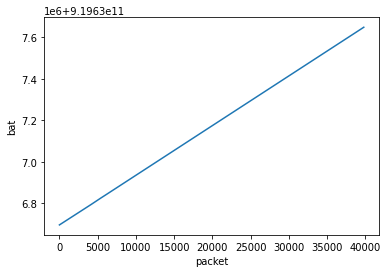

In [652]:
plot(packets['bat'])
xlabel('packet')
ylabel('bat')

Text(0, 0.5, 'BAT increment')

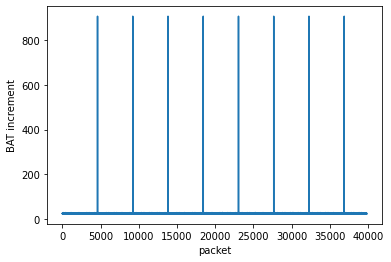

In [597]:
bat = packets['bat']
batdiff = bat[1:] - bat[:-1]
plot(batdiff[:])
xlabel('packet')
ylabel('BAT increment')

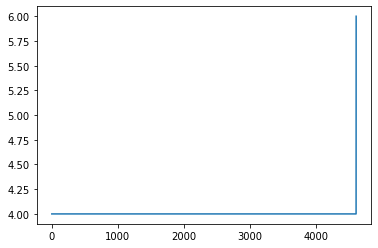

In [598]:
plot(packets['flags'][:npackets_per_frame])


In [599]:
dtype.itemsize

3752

In [600]:
32+929*4

3748

In [601]:
dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('zero2', '<u4'), ('zero3', '<u4'), ('data', '<i2', (930, 2))])

Text(0, 0.5, 'beam_number')

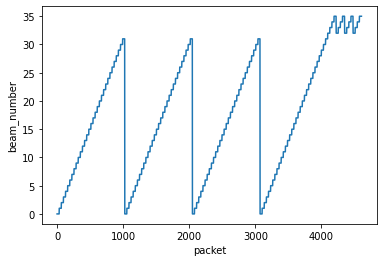

In [602]:
plot(packets['beam_number'][:npackets_per_frame])
xlabel('packet')
ylabel('beam_number')

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
[33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]


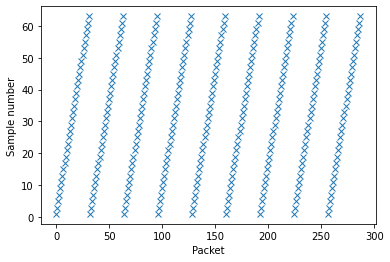

In [603]:
plot(packets['sample_number'][:npackets_per_frame//16],'x')
xlabel('Packet')
ylabel('Sample number')
print(packets['sample_number'][:16])
print(packets['sample_number'][16:32])
print(packets['sample_number'][32:48])

Text(0, 0.5, 'channel_number')

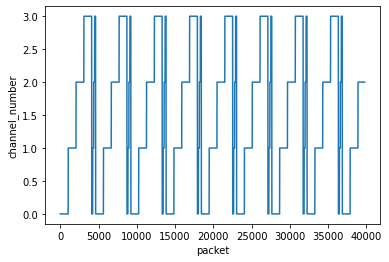

In [604]:
plot(packets['channel_number'])
xlabel('packet')
ylabel('channel_number')

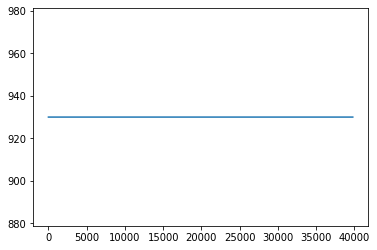

In [605]:
plot(packets['nprod'])

In [606]:
packets['data'].shape

(39799, 930, 2)

Text(0, 0.5, 'sample (beam/channel/time)')

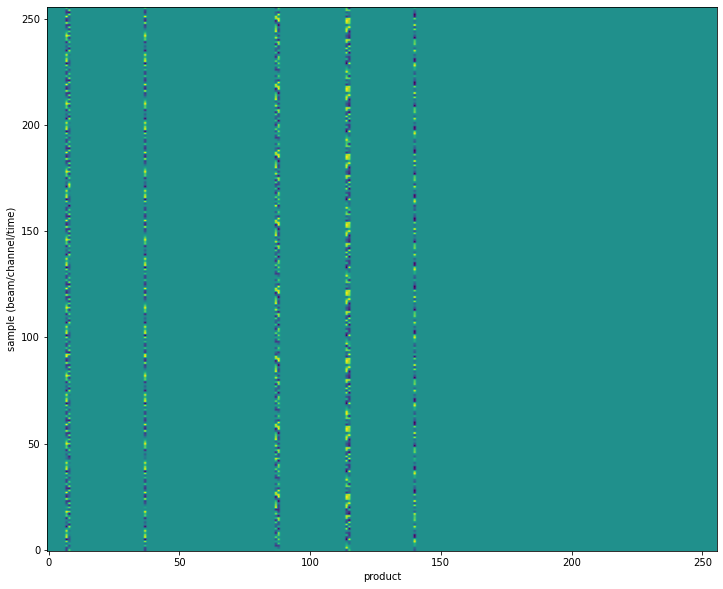

In [607]:
imshow(packets['data'][:256,:256,0], origin='lower', aspect='auto')
gcf().set_size_inches([12,10])
xlabel('product')
ylabel('sample (beam/channel/time)')


Things with nonzero real part 16
Things with nonzero imaginary part 10


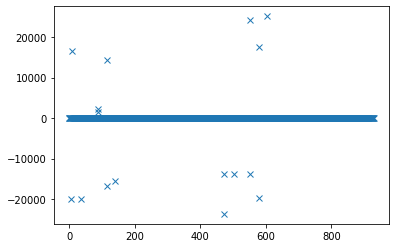

In [612]:
plot(packets['data'][0,:,0],'x')
print('Things with nonzero real part', np.sum(packets['data'][0,:,0]!=0))
print('Things with nonzero imaginary part', np.sum(packets['data'][0,:,1]!=0))
# antennas 4,5,6
# 1-1, 1-2, 1-3

In [609]:
dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('zero2', '<u4'), ('zero3', '<u4'), ('data', '<i2', (930, 2))])

In [661]:
np.where(packets['data'][0,:,0]!=0)[0]

array([  7,   8,  37,  87,  88, 114, 115, 140, 472, 473, 502, 552, 553,
       579, 580, 605])

In [669]:
imag_idxs = np.where(packets['data'][0,:,1]!=0)[0]
print(imag_idxs)

[  7   8  37  88 115 472 473 502 553 580]


In [697]:
preal = packets['data'][0,:,0]
pimag = packets['data'][0,:,1]

nant = 30
addr = 0
addrmap = {}
for a1 in range(nant):
    for a2 in range(a1, nant):
        addrmap[addr] = (a1+1, a2+1)
        addr += 1
        
print(len(addrmap))

print(np.unique(preal))
        
"""
-23702 1
-20092 2
-19736 1
-16912 1
-15480 1
-13932 1
-13722 2
"""
for addr in np.where(preal!=0)[0]:
    if addr > len(addrmap):
        pol = "pol 2"
        bladdr = addr - len(addrmap)
    else: 
        pol = "pol 1"
        bladdr = addr
        
    print(f'RAM address={addr} pol={pol} baseline={addrmap[bladdr]} real={preal[addr]} imag={pimag[addr]}')

465
[-23702 -20092 -19736 -16912 -15480 -13932 -13722      0   1420   2257
  14361  16618  17623  24211  25180]
RAM address=7 pol=pol 1 baseline=(1, 8) real=-20092 imag=-27663
RAM address=8 pol=pol 1 baseline=(1, 9) real=16618 imag=-27682
RAM address=37 pol=pol 1 baseline=(2, 9) real=-20092 imag=-27663
RAM address=87 pol=pol 1 baseline=(4, 4) real=1420 imag=0
RAM address=88 pol=pol 1 baseline=(4, 5) real=2257 imag=27934
RAM address=114 pol=pol 1 baseline=(5, 5) real=-16912 imag=0
RAM address=115 pol=pol 1 baseline=(5, 6) real=14361 imag=-252
RAM address=140 pol=pol 1 baseline=(6, 6) real=-15480 imag=0
RAM address=472 pol=pol 2 baseline=(1, 8) real=-13722 imag=30312
RAM address=473 pol=pol 2 baseline=(1, 9) real=-23702 imag=30306
RAM address=502 pol=pol 2 baseline=(2, 9) real=-13722 imag=30312
RAM address=552 pol=pol 2 baseline=(4, 4) real=-13932 imag=0
RAM address=553 pol=pol 2 baseline=(4, 5) real=24211 imag=-13618
RAM address=579 pol=pol 2 baseline=(5, 5) real=-19736 imag=0
RAM addre

In [694]:
preal.shape

(930,)

In [673]:
addrmap[7]

(1, 8)

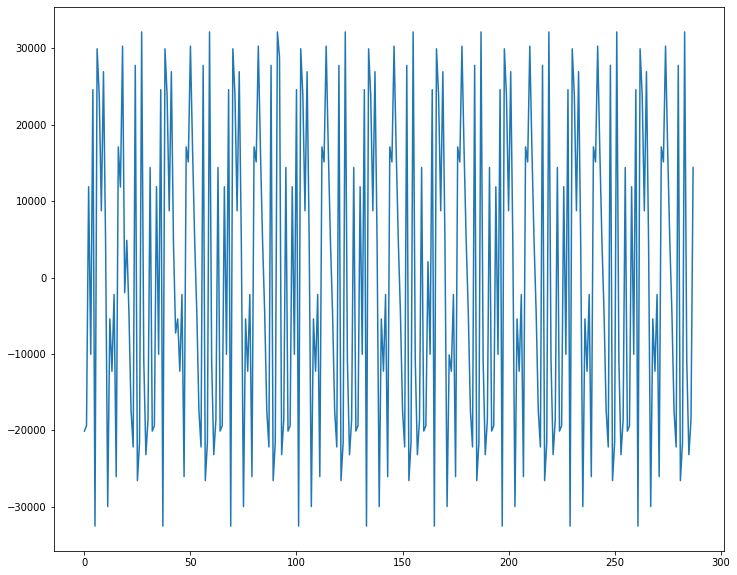

In [619]:
plot(packets['data'][:36*4*2,7,0])
gcf().set_size_inches((12,10))

In [645]:
v = packets['data'][:64*36*4,7,0].reshape(-1,32)

Text(0, 0.5, 'Channel / beam / frame')

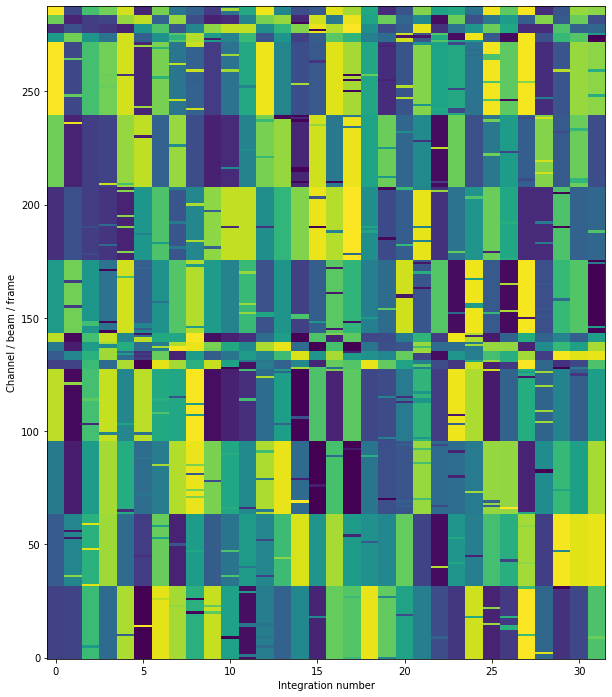

In [646]:
imshow(v, aspect='auto', origin='lower', interpolation='none')
gcf().set_size_inches((10,12))
xlabel('Integration number')
ylabel('Channel / beam / frame')

In [660]:
np.all(packets['zero2'] == 2004071455)

True

15
[-23702 -20092 -19736 -16912 -15480 -13932 -13722      0   1420   2257
  14361  16618  17623  24211  25180]


16

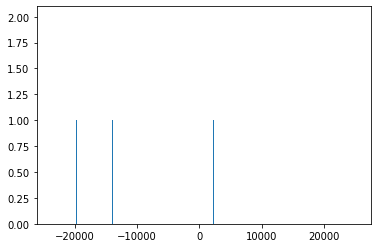

In [684]:

hist(preal[preal!=0], bins=1000)
print(len(np.unique(preal)))
print(np.unique(preal))
sum(preal!=0)


In [690]:
for v in np.unique(preal):
    print(v, sum(preal==v))
    


-23702 1
-20092 2
-19736 1
-16912 1
-15480 1
-13932 1
-13722 2
0 914
1420 1
2257 1
14361 1
16618 1
17623 1
24211 1
25180 1
